In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

from tqdm import tqdm

def get_cuda_device_or_cpu():
  if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()
    
    no = 0
    mem_available = 0

    for i in range(cuda_count):
      tmp_available = torch.cuda.mem_get_info(i)[0]
      if mem_available < tmp_available:
        no = i
        mem_available = tmp_available
    return f'cuda:{no}'
  return 'cpu'

def get_model(dim_z: int, batch_size=128, less_than=10):

  # Download training data from open datasets.
  training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
  )

  training_data.data = training_data.data[training_data.targets < less_than]
  training_data.targets = training_data.targets[training_data.targets < less_than]

  # Create data loaders.
  dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

  encoder = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 512),
    nn.Tanh(),
    nn.Linear(512, dim_z),
  )

  decoder = nn.Sequential(
    nn.Linear(2, 512),
    nn.Tanh(),
    nn.Linear(512, 512),
    nn.Tanh(),
    nn.Linear(512, 784),
    nn.Sigmoid(),
  )

  model = nn.Sequential(OrderedDict([
            ('encoder', encoder),
            ('decoder', decoder),
          ]))

  optimizer = torch.optim.Adam(model.parameters())

  return model, dataloader, optimizer

def train(model, dataloader, optimizer, run, epochs=5):
  
  device = get_cuda_device_or_cpu()
  print(device)
  
  model.to(device)
  model.train()

  hist = torch.zeros(0)

  for _ in tqdm(range(epochs)):
    tmp = run(model, dataloader, optimizer, device)
    hist = torch.cat([hist, tmp])
  
  return hist

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
def run_un(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()

  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)
    z = model.get_submodule('encoder')(x)
    pred = model.get_submodule('decoder')(z)
    loss = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist
  
model, dataloader, optimizer = get_model(dim_z=2)
hist = train(model, dataloader, optimizer, run_un, 5)
plt.plot(hist)
plt.show()

cuda:1


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [6]:
model, dataloader, optimizer = get_model(dim_z=2, batch_size=60000)

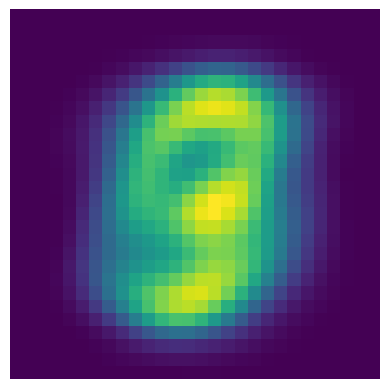

In [7]:
for x, y in dataloader:
  print()
  plt.imshow(x.mean(dim=0)[0].view([28, 28]))
  plt.axis('off')
  break